# Train Model

### Imports

In [1]:
import sys
import os
from config import Config
sys.path.append(Config.root_path)

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
# Load Model
from Python.model.segmentation_model import deeplabv3plus
# Load Dataset & Preprocessing
from Python.data_processing.utils import get_png_paths_from_dir
from Python.data_processing.utils import load_weight_map
from Python.data_processing.utils import split_dataset_paths
from Python.data_processing.data_generator import generate_image_dataset_from_files
from Python.data_processing.data_generator import split_dataset
from Python.data_processing.data_generator import augment_dataset
# Print Model Prediction
from Python.data_processing.compare_predictions import show_predictions
# Save Model
from Python.data_processing.save_model import write_model_to_disk


print(tf.config.list_physical_devices('GPU'))

2023-03-30 19:20:54.073542: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-30 19:20:55.187649: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/lib/:/home/vidarmarsh/miniconda3/envs/tf/lib/
2023-03-30 19:20:55.187746: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/lib/:/home/vidarmarsh/miniconda3/envs/tf/lib/
2023-03-30 19:20:55.187756: W tens

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2023-03-30 19:20:56.686996: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-03-30 19:20:56.720880: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-03-30 19:20:56.720927: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


### Prepare dataset

In [2]:
image_files = get_png_paths_from_dir(Config.image_path)
mask_files = get_png_paths_from_dir(Config.segmentation_path)
weight_map = load_weight_map(Config.weight_map_path)
weights = np.zeros(Config.output_channels, dtype=float)
for key in weight_map.keys():
    weights[int(key)] = weight_map.get(key)

train_files, val_files, test_files = split_dataset_paths(
    image_files, 
    mask_files, 
    Config.train_size, 
    Config.val_size, 
    Config.test_size 
)
train_dataset, val_dataset, test_dataset = [
    generate_image_dataset_from_files(
        img_files, 
        msk_files,
        Config.batch_size,
        tf.data.AUTOTUNE, 
        Config.shuffle_size, 
        weights
    ) for img_files, msk_files in [train_files, val_files, test_files]
]
dataset = generate_image_dataset_from_files(
    image_files, 
    mask_files, 
    Config.batch_size,
    tf.data.AUTOTUNE, 
    Config.shuffle_size, 
    weights
)
train_dataset, val_dataset, test_dataset = split_dataset(
    dataset, Config.train_size, Config.val_size, Config.test_size
)
train_dataset = augment_dataset(train_dataset)

2023-03-30 19:20:56.793007: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-30 19:20:56.796290: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-03-30 19:20:56.796353: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-03-30 19:20:56.796376: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_nod

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


### Load Model

In [3]:
model = deeplabv3plus(
    Config.input_shape,
    Config.batch_size,
    Config.output_channels,
    Config.channels_low,
    Config.channels_high,
    Config.middle_repeat
)
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics = ["accuracy"]
)

### Compare Image, Segmentation Mask and Prediction

1/1 [==============================] - 0s 34ms/step


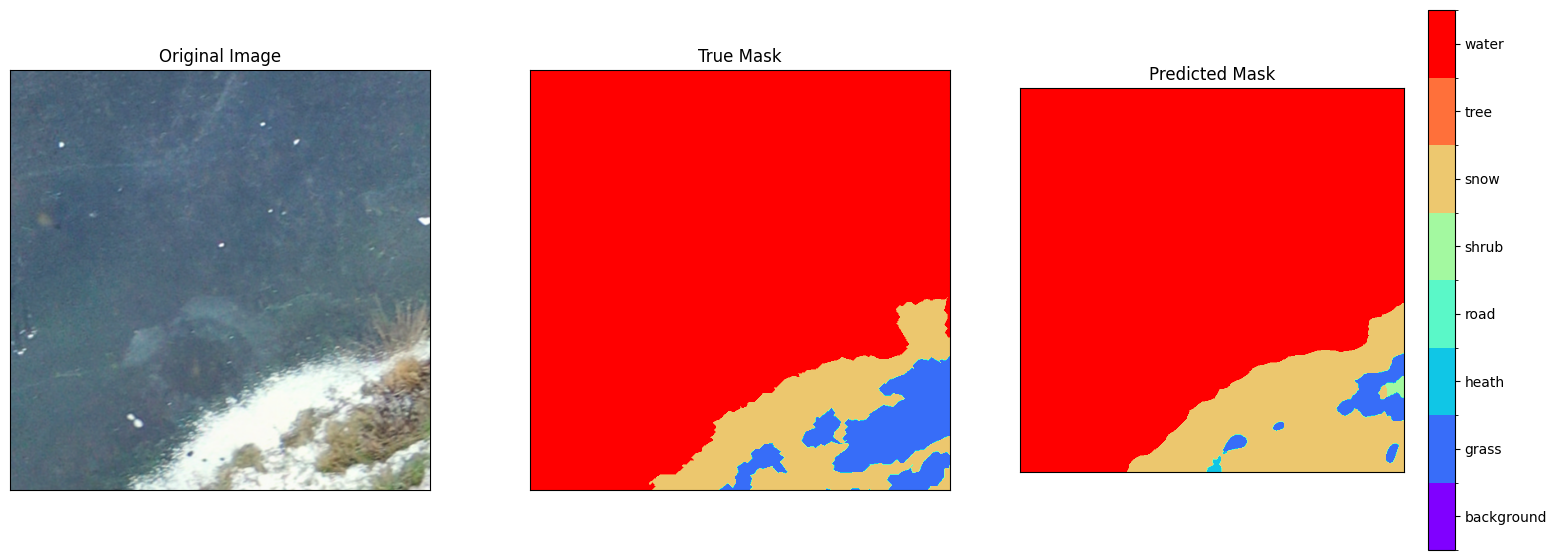

In [62]:
show_predictions(model, dataset)

### Model Training

Train Model

In [46]:
model_history = model.fit(
    train_dataset,
    epochs=20,
    validation_data=val_dataset,
    shuffle=True
) 

Epoch 1/20
101/101 [==============================] - 44s 432ms/step - loss: 0.0969 - accuracy: 0.8903 - val_loss: 0.8752 - val_accuracy: 0.8057
Epoch 2/20
101/101 [==============================] - 44s 437ms/step - loss: 0.0959 - accuracy: 0.8906 - val_loss: 1.8615 - val_accuracy: 0.8865
Epoch 3/20
101/101 [==============================] - 44s 439ms/step - loss: 0.1247 - accuracy: 0.8834 - val_loss: 0.5603 - val_accuracy: 0.9224
Epoch 4/20
101/101 [==============================] - 44s 439ms/step - loss: 0.1095 - accuracy: 0.8809 - val_loss: 1.6883 - val_accuracy: 0.8342
Epoch 5/20
101/101 [==============================] - 45s 440ms/step - loss: 0.0900 - accuracy: 0.8922 - val_loss: 1.2650 - val_accuracy: 0.9139
Epoch 6/20
101/101 [==============================] - 45s 440ms/step - loss: 0.0893 - accuracy: 0.8912 - val_loss: 1.7115 - val_accuracy: 0.8707
Epoch 7/20
101/101 [==============================] - 45s 441ms/step - loss: 0.0831 - accuracy: 0.8975 - val_loss: 3.5995 - val_ac

Show Model Performance

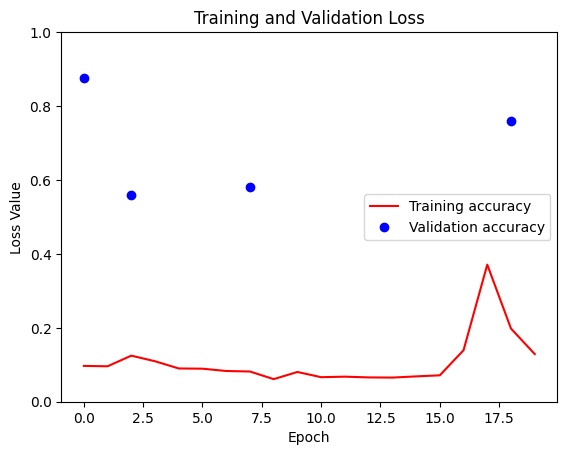

In [47]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.figure()
plt.plot(model_history.epoch, loss, 'r', label='Training accuracy')
plt.plot(model_history.epoch, val_loss, 'bo', label='Validation accuracy')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

### Save Model

In [1]:
train_names = [os.path.split(img_path)[1] for img_path in train_files[0]]
val_names = [os.path.split(img_path)[1] for img_path in val_files[0]]
test_names = [os.path.split(img_path)[1] for img_path in test_files[0]]
file_partitions = dict(
    "train", train_files, "validation", val_files, "test", test_files
)
write_model_to_disk(
    model, model_history, file_partitions, Config.model_dir_path, Config
)

NameError: name 'write_model_to_disk' is not defined